<a href="https://colab.research.google.com/github/pyrdesilva/Impact-of-Screen-Time-Patterns-/blob/main/Impact_of_Screen_Time_Patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import ScalarFormatter
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import os

In [3]:
#Mount the Google drive to the Colab notebook.
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Install Kaggle API.
!pip install kaggle

In [4]:
#Change the current working directory, where to download the Kaggle dataset.
# files will be present in "/content/drive/My Drive/ColabNotebooks/".
%cd /content/drive/My Drive/ColabNotebooks/

/content/drive/My Drive/ColabNotebooks


In [ ]:
#Configure the path to “kaggle.json”.
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/ColabNotebooks/'

**Data Acquisition**

In [ ]:
#Download the dataset 01.
!kaggle datasets download -d 'yajkotak/mental-health-and-screen-time-correlation-dataset'

Dataset URL: https://www.kaggle.com/datasets/yajkotak/mental-health-and-screen-time-correlation-dataset
License(s): apache-2.0
mental-health-and-screen-time-correlation-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Download the dataset 02.
!kaggle datasets download -d 'muhammadalirazazaidi/screen-time-data-productivity-and-attention-span'

Dataset URL: https://www.kaggle.com/datasets/muhammadalirazazaidi/screen-time-data-productivity-and-attention-span
License(s): MIT
screen-time-data-productivity-and-attention-span.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Run the “ls” command to check the dataset files.
!ls *.zip

In [ ]:
#Rename the zip files to avoid '-' inbetween the file names
try:
  os.rename('mental-health-and-screen-time-correlation-dataset.zip', 'mental_health_and_screen_time_correlation_dataset.zip')
  os.rename('screen-time-data-productivity-and-attention-span.zip', 'screen_time_data_productivity_and_attention_span.zip')
  !ls *.zip
except FileNotFoundError:
  print(f"Error: File not found")

In [ ]:
#Unzip the data and remove the zip file if necessary only #rm *.zip
!unzip /content/drive/MyDrive/ColabNotebooks/mental_health_and_screen_time_correlation_dataset.zip -d /content/drive/MyDrive/ColabNotebooks/SeminarTask3

Archive:  /content/drive/MyDrive/ColabNotebooks/mental_health_and_screen_time_correlation_dataset.zip
  inflating: /content/drive/MyDrive/ColabNotebooks/SeminarTask3/mental_health_screen_time_dataset.csv  


In [ ]:
#Unzip the data and remove the zip file if necessary only
!unzip /content/drive/MyDrive/ColabNotebooks/screen_time_data_productivity_and_attention_span.zip -d /content/drive/MyDrive/ColabNotebooks/SeminarTask3

Archive:  /content/drive/MyDrive/ColabNotebooks/screen_time_data_productivity_and_attention_span.zip
  inflating: /content/drive/MyDrive/ColabNotebooks/SeminarTask3/data.csv  


In [ ]:
!ls /content/drive/MyDrive/ColabNotebooks/SeminarTask3/*.csv
#Rename the csv files to its original file names, just for identifications
os.rename('/content/drive/MyDrive/ColabNotebooks/SeminarTask3/mental_health_screen_time_dataset.csv', '/content/drive/MyDrive/ColabNotebooks/SeminarTask3/mental_health_and_screen_time_correlation_dataset.csv')
os.rename('/content/drive/MyDrive/ColabNotebooks/SeminarTask3/data.csv', '/content/drive/MyDrive/ColabNotebooks/SeminarTask3/screen_time_data_productivity_and_attention_span.csv')

/content/drive/MyDrive/ColabNotebooks/SeminarTask3/data.csv
/content/drive/MyDrive/ColabNotebooks/SeminarTask3/mental_health_screen_time_dataset.csv


In [ ]:
!ls /content/drive/MyDrive/ColabNotebooks/SeminarTask3/*.csv

In [ ]:
# Load the dataset
file_path1 = '/content/drive/MyDrive/ColabNotebooks/SeminarTask3/mental_health_and_screen_time_correlation_dataset.csv'
df_mental_health = pd.read_csv(file_path1)

# Display first few rows and info
df_mental_health.head(), df_mental_health.info()

In [ ]:
# Load the re-uploaded dataset
file_path2 = '/content/drive/MyDrive/ColabNotebooks/SeminarTask3/screen_time_data_productivity_and_attention_span.csv'
df_screen_time = pd.read_csv(file_path2)

# Display first few rows and info
df_screen_time.head(), df_screen_time.info()

In [8]:
#Columns to migrate from the Productivity & Attention Span dataset into the Mental Health dataset for better analysis.
#Define columns that add value for EDA
columns_to_migrate = ["Age Group", "Gender", "Occupation", "Productivity", "Attention Span",
                      "Work Strategy", "Screen Activity", "Notification Handling", "Usage of Productivity Apps" ]

# Extract those columns from the productivity dataset
df_screen_time_subset = df_screen_time[columns_to_migrate].copy()

#Expand the productivity data to match the number of rows in the health dataset
df_screen_time_expanded = df_screen_time_subset.sample(
    n=len(df_mental_health),
    replace=True,
    random_state=42  # makes the results reproducible
).reset_index(drop=True)

# Step 4: Merge both datasets side-by-side
df_mental_health_merged = pd.concat([df_mental_health.reset_index(drop=True), df_screen_time_expanded], axis=1)

In [ ]:
# Display first few rows and info of the combined dataset
df_mental_health_merged.head(), df_mental_health_merged.info()

**Clean and preprocess the data**

In [ ]:
# Handling Missing Values. Missing data can skew results or break machine learning algorithms.
# Check for missing values
df_mental_health_merged.isnull().sum()

In [ ]:
#Return the count of unique occurrences in this column. Sort the results obtained in ascending order
df_mental_health_merged['Work Strategy'].value_counts(ascending=True)

In [ ]:
#Impute missing values
df_mental_health_merged['Work Strategy'].fillna('Use some productivity tool (e.g, timers, blockers)', inplace=True)

In [ ]:
df_mental_health_merged['Notification Handling'].value_counts(ascending=True)

In [14]:
df_mental_health_merged['Notification Handling'] = df_mental_health_merged['Notification Handling'].fillna('Spend time interacting with the notifications')

**Convert Categorical Variables to Numeric (Ordinal Encoding / One-Hot Encoding)**

ML models typically require numerical inputs. Use one-hot encoding for non-ordinal/nominal categorical features and label encoding for ordinal date.

In [ ]:
#df_mental_health_merged['Gender'].value_counts(ascending=True)
unique_genders = df_mental_health_merged['Gender'].unique()
print(unique_genders)

In [ ]:
# One-Hot Encoding for nominal (unordered) categories
#https://www.geeksforgeeks.org/ml-one-hot-encoding/

nominal_cols = ['Gender'] #, 'Occupation', 'Work Strategy', 'Notification Handling', 'Usage of Productivity Apps']
# Create a prefix list with the same length as the columns being encoded
prefix_list = ['Gender']
# Apply one-hot encoding using the prefix list
df_mental_health_encoded = pd.get_dummies(df_mental_health_merged, columns=nominal_cols, prefix=prefix_list, drop_first=True)
df_mental_health_encoded

In [ ]:
df_mental_health_encoded['Gender_Male'].value_counts(ascending=True)

In [ ]:
df_mental_health_encoded['Attention Span'].value_counts(ascending=True)

In [ ]:
#Ordinal Encoding for Ordinal Columns.
#Ordinal Encoding assigns a unique integer to each category, similar to Label Encoding. It ensures that the order of categories is preserved.
#https://www.geeksforgeeks.org/encoding-categorical-data-in-sklearn/#3-ordinal-encoding

from sklearn.preprocessing import OrdinalEncoder

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[['Less than 10 minutes', '10–30 minutes', '30–60 minutes', 'More than 1 hour']])

# Ordinal Encoding for ordered categories
ordinal_cols = ['Attention Span']
for col in ordinal_cols:
  # Fit and transform the data
  df_mental_health_encoded[col] = ordinal_encoder.fit_transform(df_mental_health_encoded[[col]])

df_mental_health_encoded

In [ ]:
df_mental_health_encoded['Attention Span'].value_counts(ascending=True)

In [ ]:
df_mental_health_merged['Productivity'].value_counts(ascending=True)

In [ ]:
#Ordinal Encoding for Ordinal Columns.
#Ordinal Encoding assigns a unique integer to each category, similar to Label Encoding. It ensures that the order of categories is preserved.
#https://www.geeksforgeeks.org/encoding-categorical-data-in-sklearn/#3-ordinal-encoding

from sklearn.preprocessing import OrdinalEncoder

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[['Unproductive, i might not have completed the task and got carried away', 'Moderately productive','Extremely productive, i efficiently complete my tasks']])

# Ordinal Encoding for ordered categories
ordinal_cols = ['Productivity']
for col in ordinal_cols:
  # Fit and transform the data
  df_mental_health_encoded[col] = ordinal_encoder.fit_transform(df_mental_health_encoded[[col]])

df_mental_health_encoded

In [ ]:
df_mental_health_encoded['Productivity'].value_counts(ascending=True)

**Feature Engineering**

In [ ]:
#Creating new features can capture relationships better than raw data.
#Average recommanded sleep 8 hourse
RECOMMENDED_SLEEP = 8
df_mental_health_merged['Sleep_Deficit'] = RECOMMENDED_SLEEP - df_mental_health_merged['Sleep_Duration']
print(df_mental_health_merged[['Sleep_Duration', 'Sleep_Deficit']])

**Standardize/Normalize Numerical Columns**

In [ ]:
# Check current format
print(df_mental_health_encoded['Sleep_Duration'].head())

In [ ]:
# Columns of  Daily_Screen_Time, App_Social_Media_Time, App_Work_Time and App_Entertainment_Time are in minutes. But Sleep_Duration on different scale of hours.
# To ensure all numerical columns are on the same unit scale (minutes), convert Sleep_Duration from hours to minutes.

#df_mental_health_merged = df_mental_health_encoded
# Check current format
print(df_mental_health_merged['Sleep_Duration'].head())
# Convert hours to minutes (1 hour = 60 minutes)
df_mental_health_merged['Sleep_Duration_Minutes'] = df_mental_health_merged['Sleep_Duration'] * 60
df_mental_health_encoded['Sleep_Duration'] = df_mental_health_encoded['Sleep_Duration'] * 60

# Optional: Drop old 'Sleep_Duration' column
#df_mental_health_merged.drop('Sleep_Duration', axis=1, inplace=True)
# Rename to keep column names consistent
#df_mental_health_merged.rename(columns={'Sleep_Duration_Minutes': 'Sleep_Duration'}, inplace=True)

# Verify the result
print(df_mental_health_merged[['Sleep_Duration_Minutes']].head())
print(df_mental_health_encoded[['Sleep_Duration']].head())


In [ ]:
#Daily_Screen_Time ranges from 100–600 minutes but App_Work_Time ranges from 5–90 minutes, then without scaling, the larger-scale feature will dominate the learning process.
#After standardization, all features contribute equally and comparisons become fair.
#Techniques like Standardization (Z-score normalization) where each column is transformed to have a mean of 0 and standard deviation of 1


from sklearn.preprocessing import StandardScaler
# List of time-based features in minutes
timeduration_columns = ['Daily_Screen_Time', 'App_Social_Media_Time', 'App_Work_Time', 'App_Entertainment_Time', 'Sleep_Duration']

# Initialize the scaler
scaler = StandardScaler()
# Fit and transform the time-based columns
df_mental_health_merged_scaled = df_mental_health_encoded.copy()
df_mental_health_merged_scaled[timeduration_columns] = scaler.fit_transform(df_mental_health_merged[timeduration_columns])

# Print mean and std of each column
print(df_mental_health_merged_scaled[timeduration_columns].mean())
print(df_mental_health_merged_scaled[timeduration_columns].std())


**Change the order of a Pandas DataFrame columns**

In [ ]:
#https://www.geeksforgeeks.org/change-the-order-of-a-pandas-dataframe-columns-in-python/
#Present dataframe column order
df_mental_health_merged_scaled.columns.tolist()
# Reordering columns using loc
df_mental_health_merged_reordered = df_mental_health_merged_scaled.loc[:, [ 'Participant_ID',
                                                                            'Date',
                                                                            'Gender_Male',
                                                                            'Age Group',
                                                                            'Occupation',
                                                                            'Daily_Screen_Time',
                                                                            'App_Social_Media_Time',
                                                                            'App_Work_Time',
                                                                            'App_Entertainment_Time',
                                                                            'Phone_Unlocks',
                                                                            'Screen Activity',
                                                                            'Sleep_Duration',
                                                                            'Well_Being_Score',
                                                                            'Stress_Level',
                                                                            'Mood_Rating',
                                                                            'Attention Span',
                                                                            'Work Strategy',
                                                                            'Notification Handling',
                                                                            'Usage of Productivity Apps',
                                                                            'Productivity'    ]]
df_mental_health_merged_reordered.head()

In [ ]:
#  Data Cleaning and Preprocessing Continuation for Analysis ---
# Rename columns to be more Python-friendly (remove spaces, special chars)
df_mental_health_merged_reordered.columns = df_mental_health_merged_reordered.columns.str.replace(' ', '_', regex=False).str.replace('[^A-Za-z0-9_]+', '', regex=True)
print("\nCleaned Column Names:")
print(df_mental_health_merged_reordered.columns)

# Convert Gender_Male (currently boolean) to integer (0 or 1) for easier analysis
df_mental_health_merged_reordered['Gender_Male'] = df_mental_health_merged_reordered['Gender_Male'].astype(int)

# Filter for the target age group (18-34) as per research question
age_groups_to_include = ['18–24', '25–34']
df_mental_health_merged_reordered_filtered = df_mental_health_merged_reordered[df_mental_health_merged_reordered['Age_Group'].isin(age_groups_to_include)].copy()
print(f"\nFiltered dataset shape (Age 18-34): {df_mental_health_merged_reordered_filtered.shape}")

# Clean up the Age Group column (remove special character)
df_mental_health_merged_reordered_filtered['Age_Group_Clean'] = df_mental_health_merged_reordered_filtered['Age_Group'].str.replace('–', '_', regex=False)

In [29]:
#Export Data to CSV/Excel

#Change the current working directory
# files will be present in "/content/drive/My Drive/ColabNotebooks/"
%cd /content/drive/My Drive/ColabNotebooks/

df_mental_health_merged_reordered.to_csv('df_mental_health_merged_reordered.csv', index=False)
#df_mental_health_merged_reordered_filtered.to_excel('df_mental_health_merged_reordered.xlsx', index=False)
# Print a message indicating the export was successful
print('Data exported to CSV/Excel successfully.')

/content/drive/My Drive/ColabNotebooks
Data exported to CSV/Excel successfully.


**Exploratory Data Analysis with Visualizations**

Univariate Analysis. Histograms are good for showing general distributional features of dataset variables. Looking at our variables which are all continuous numeric values. The histograms in below shows a frequency distribution for every variable, 'Daily_Screen_Time', 'App_Social_Media_Time', 'App_Work_Time',  'App_Entertainment_Time', and 'Sleep_Duration' recorded in minutes.

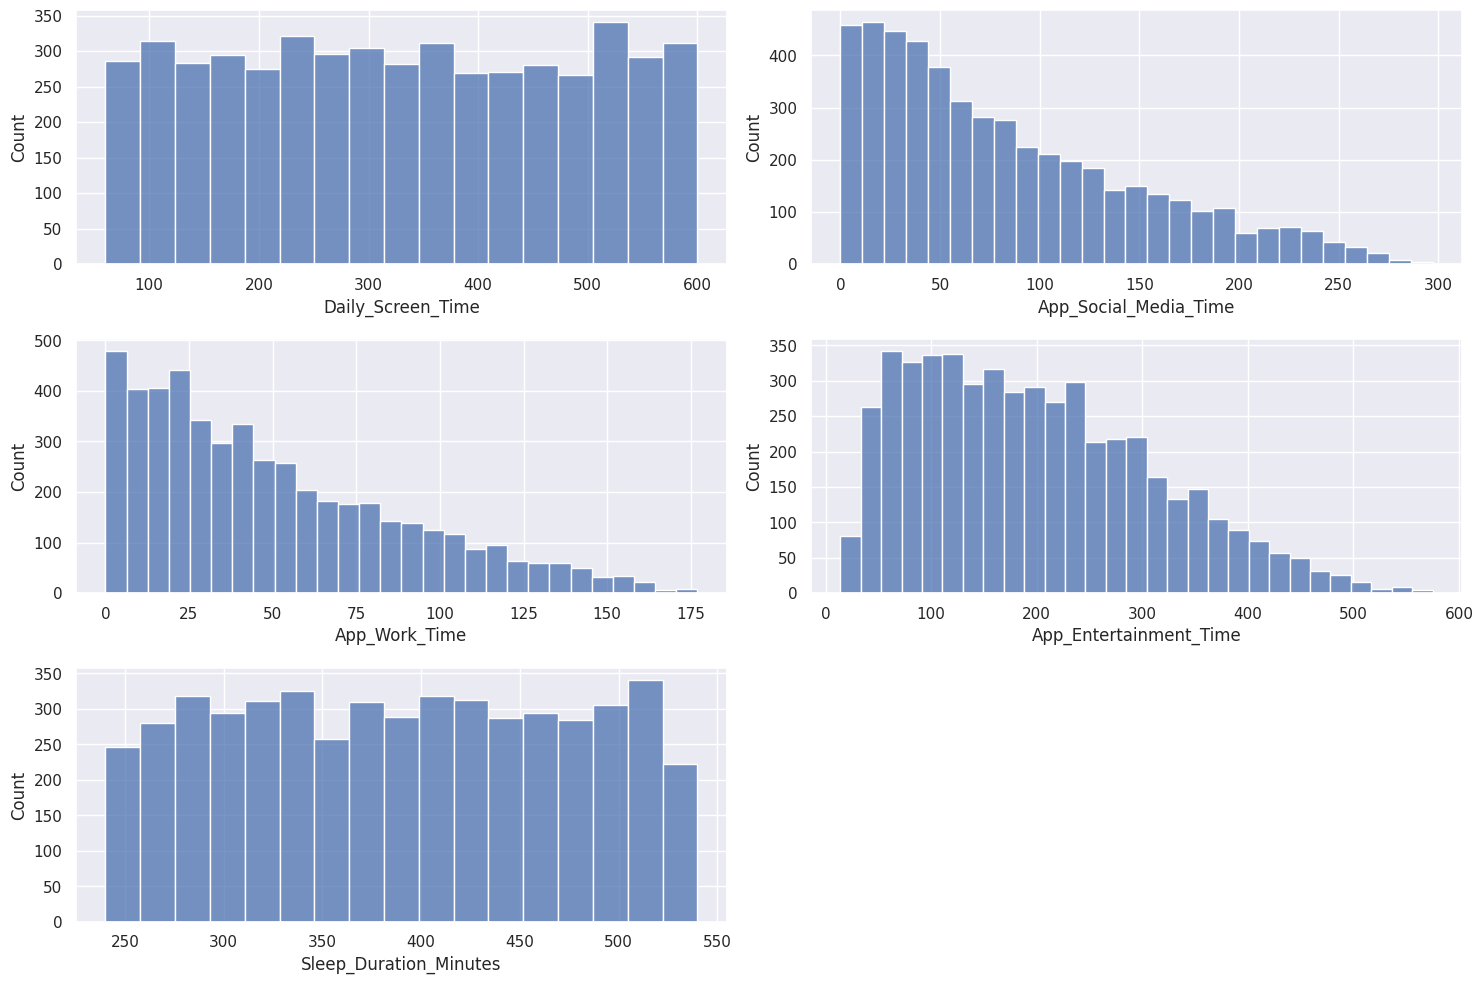

In [30]:
plt.figure(figsize=(15, 10))
sns.set(color_codes=True)

def create_histogram(data, subplot_position):
    ax = plt.subplot(3, 2, subplot_position)
    sns.histplot(data, kde=False, ax=ax)

    # Define the format
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(useOffset=False)

#histogramas
create_histogram(df_mental_health_merged['Daily_Screen_Time'], 1)
create_histogram(df_mental_health_merged['App_Social_Media_Time'], 2)
create_histogram(df_mental_health_merged['App_Work_Time'], 3)
create_histogram(df_mental_health_merged['App_Entertainment_Time'], 4)
create_histogram(df_mental_health_merged['Sleep_Duration_Minutes'], 5)

plt.tight_layout()
plt.show()


Distribution Plots for Key Numerical Predictors:

Distribution Plots for Key Numerical Outcomes:


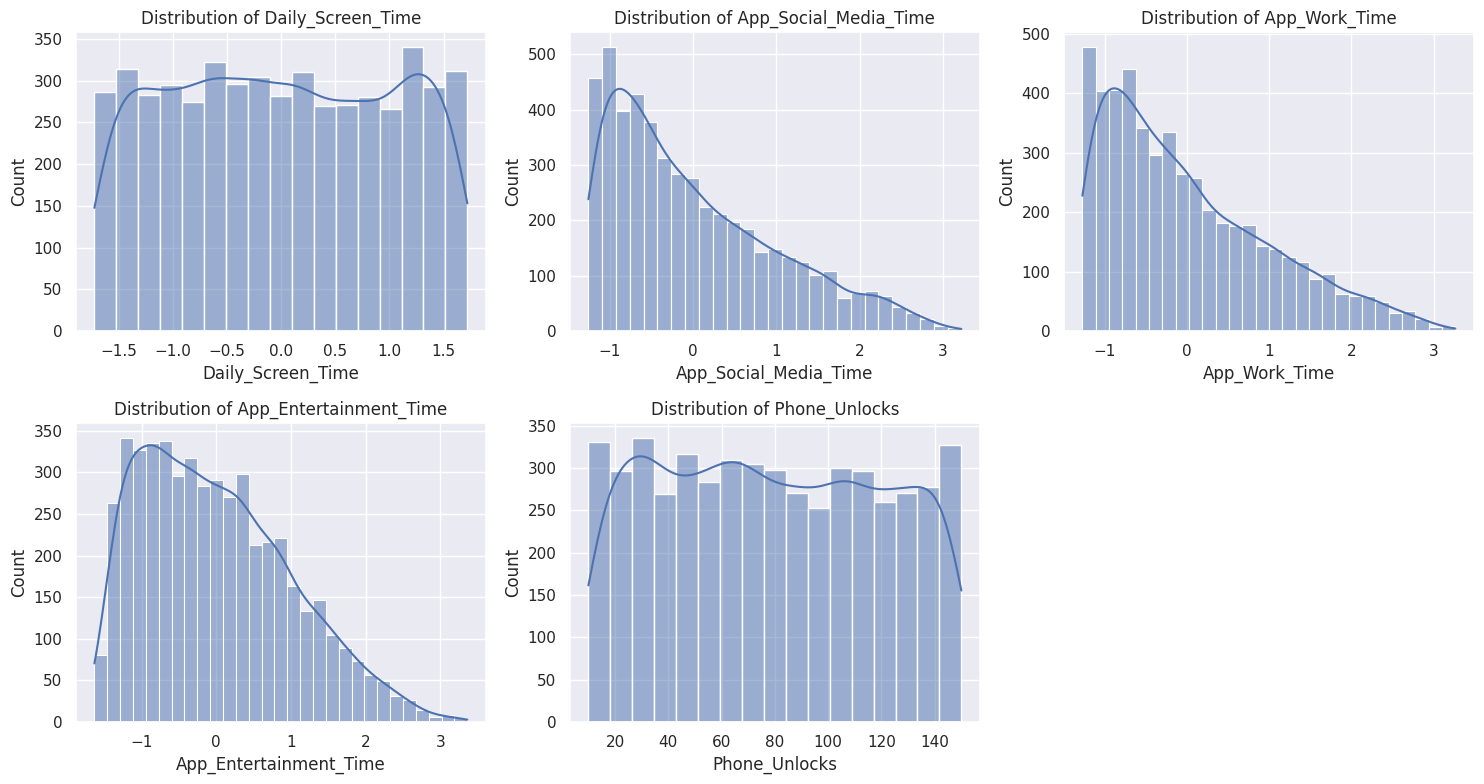

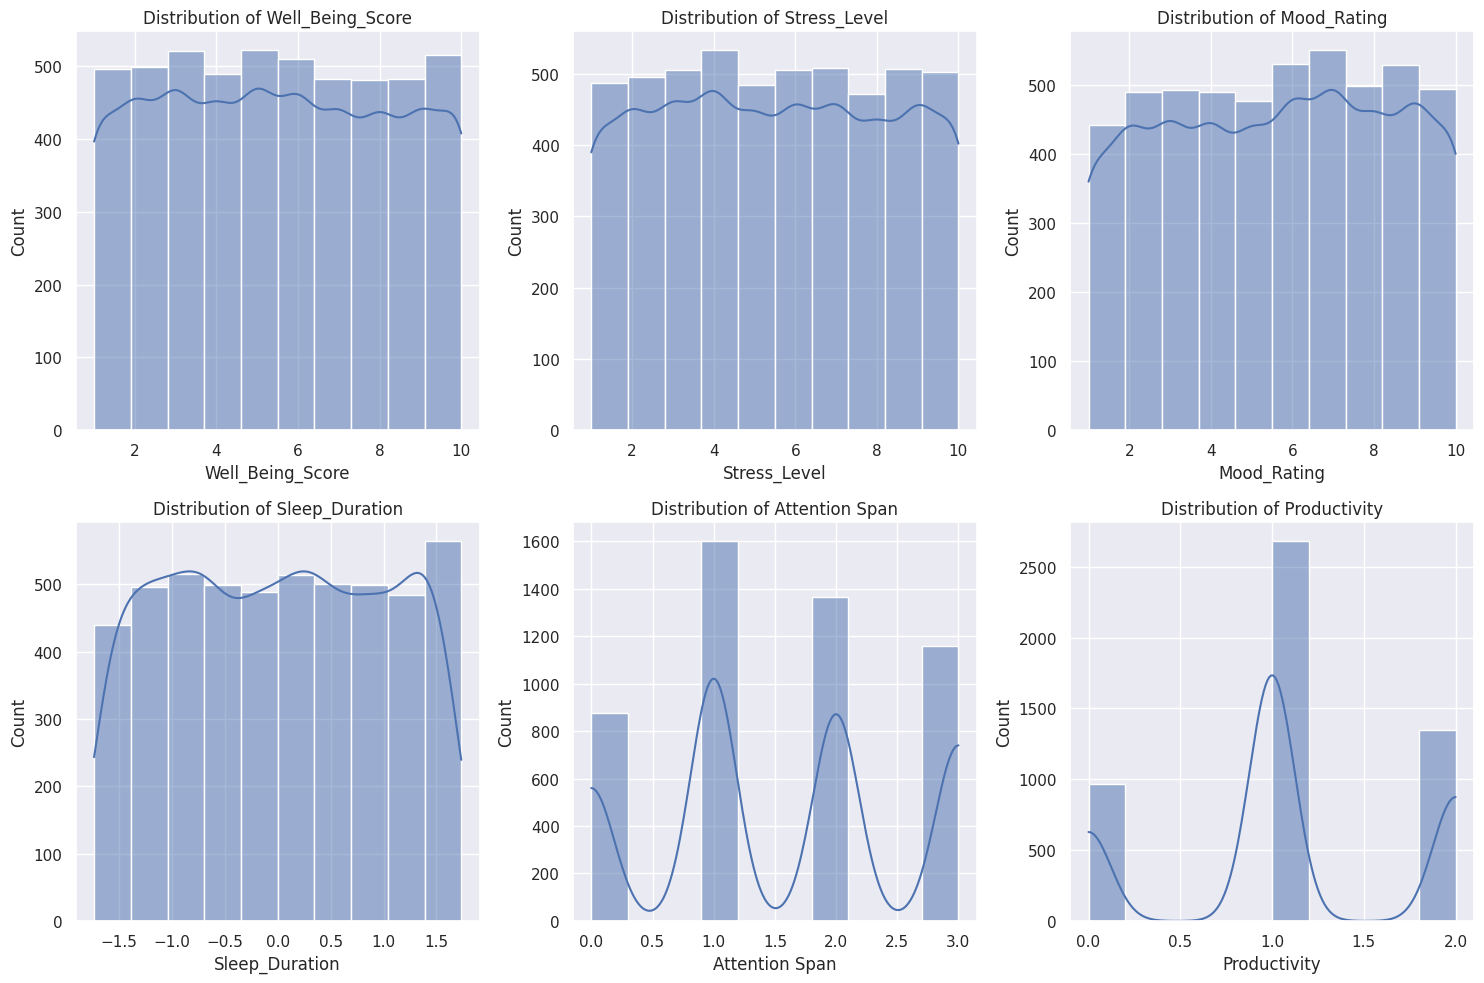

In [32]:
# Univariate Analysis (Distributions of Key Numerical Variables)
numerical_outcomes = ['Well_Being_Score', 'Stress_Level', 'Mood_Rating', 'Sleep_Duration', 'Attention Span', 'Productivity']
numerical_predictors = ['Daily_Screen_Time', 'App_Social_Media_Time', 'App_Work_Time', 'App_Entertainment_Time', 'Phone_Unlocks']

print("\nDistribution Plots for Key Numerical Predictors:")
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_predictors):
     if col in df_mental_health_merged_reordered.columns:
        plt.subplot(2, 3, i + 1)
        sns.histplot(df_mental_health_merged_reordered[col], kde=True)
        plt.title(f'Distribution of {col}')
     else:
         print(f"Warning: Predictor column '{col}' not found.")
plt.tight_layout()
#plt.show()

print("\nDistribution Plots for Key Numerical Outcomes:")
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_outcomes):
    if col in df_mental_health_merged_reordered.columns:
        plt.subplot(2, 3, i + 1)
        sns.histplot(df_mental_health_merged_reordered[col], kde=True, bins=10) # Using bins=10 as many are scales
        plt.title(f'Distribution of {col}')
    else:
         print(f"Warning: Outcome column '{col}' not found.")
plt.tight_layout()
#plt.show()

In [33]:
#Number of times the phone unlocks for screen activity
#Variable of interest is not continuous, but instead discrete or categorical, use a bar chart.
figure = px.bar(data_frame=df_mental_health_merged,
                x="Date",
                y="Phone_Unlocks",
                color="Screen Activity",
                title="Phone Unlocks for Screen Activity")
figure.show()

In [34]:
#Daily Screen Time based on Gender
figure = px.bar(data_frame=df_mental_health_merged,
                x="Date",
                y="Daily_Screen_Time",
                color="Gender",
                title="Daily Screen Time based on Gender")
figure.show()

In [35]:
#Daily Screen Time based on Age Group
figure = px.bar(data_frame=df_mental_health_merged,
                x="Date",
                y="Daily_Screen_Time",
                color="Age Group",
                title="Daily Screen Time based on Age Group")
figure.show()

Bivariate analysis examining the continuous variables in relation to each other, variables in particular that show a relationship with the amount of Sleep_Duration. We could observe a pattern: the more a person spends time on the screen, the higher the probability of having a poor night's sleep.

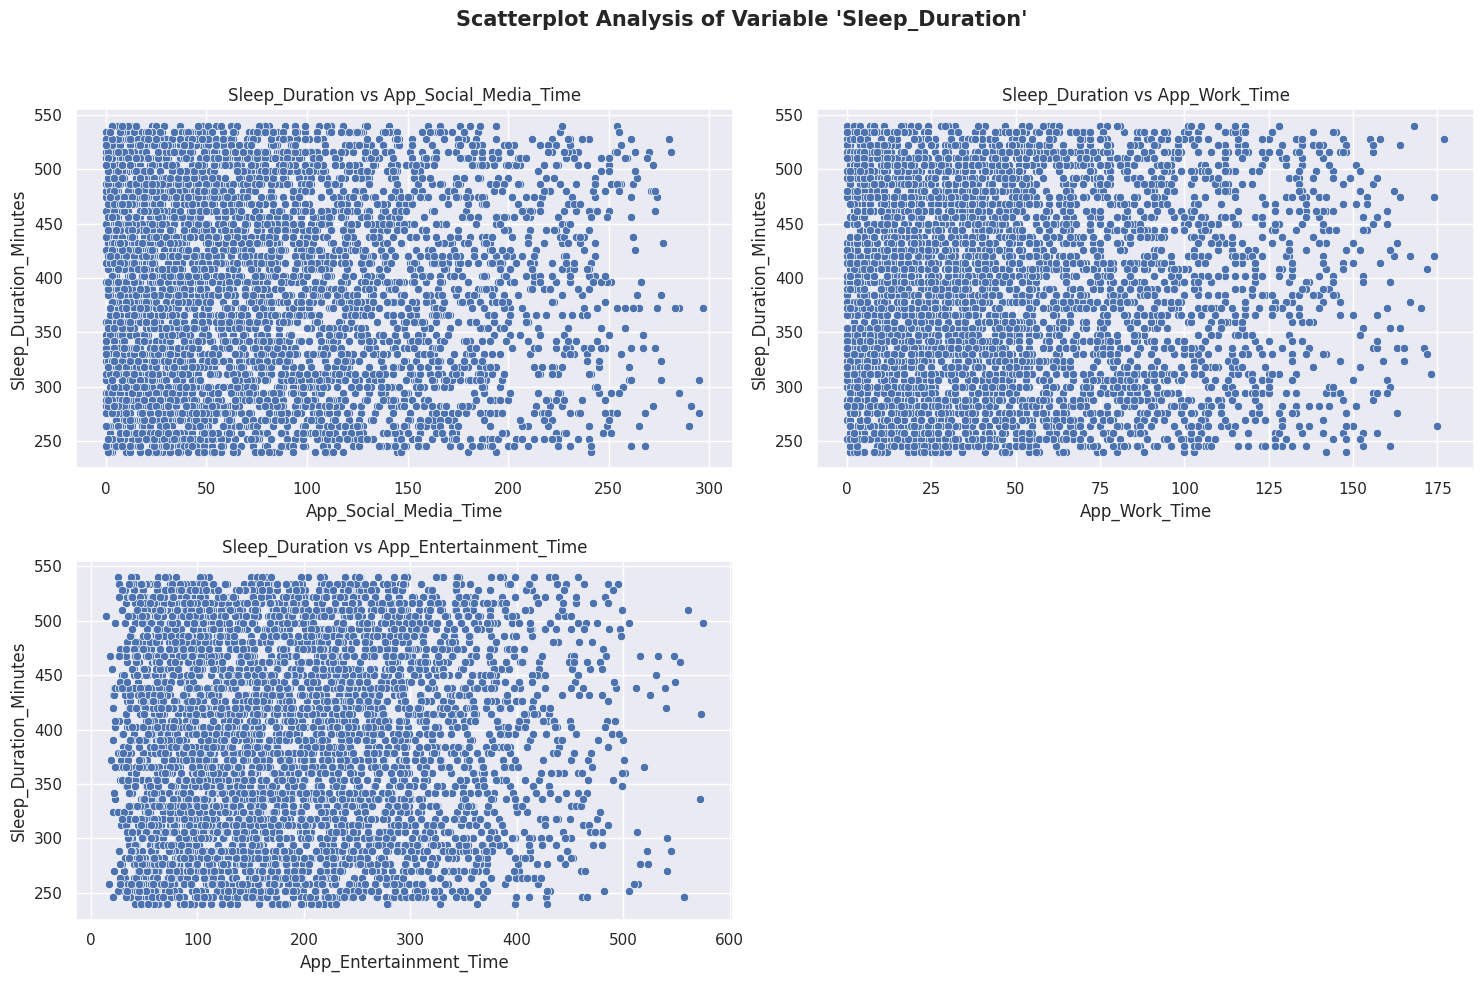

In [36]:
plt.figure(figsize=(15, 10))
plt.suptitle("Scatterplot Analysis of Variable 'Sleep_Duration'", fontweight="bold", fontsize=15)
axes = []
# Primeiro gráfico: Scatterplot
axes.append(plt.subplot(2, 2, 1))
sns.scatterplot(x='App_Social_Media_Time', y='Sleep_Duration_Minutes', data=df_mental_health_merged)
plt.title('Sleep_Duration vs App_Social_Media_Time')

axes.append(plt.subplot(2, 2, 2))
sns.scatterplot(x='App_Work_Time', y='Sleep_Duration_Minutes', data=df_mental_health_merged)
plt.title('Sleep_Duration vs App_Work_Time')

axes.append(plt.subplot(2, 2, 3))
sns.scatterplot(x='App_Entertainment_Time', y='Sleep_Duration_Minutes', data=df_mental_health_merged)
plt.title('Sleep_Duration vs App_Entertainment_Time')

for ax in axes:
    ax.ticklabel_format(style='plain', axis='both')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Correlation Heatmap

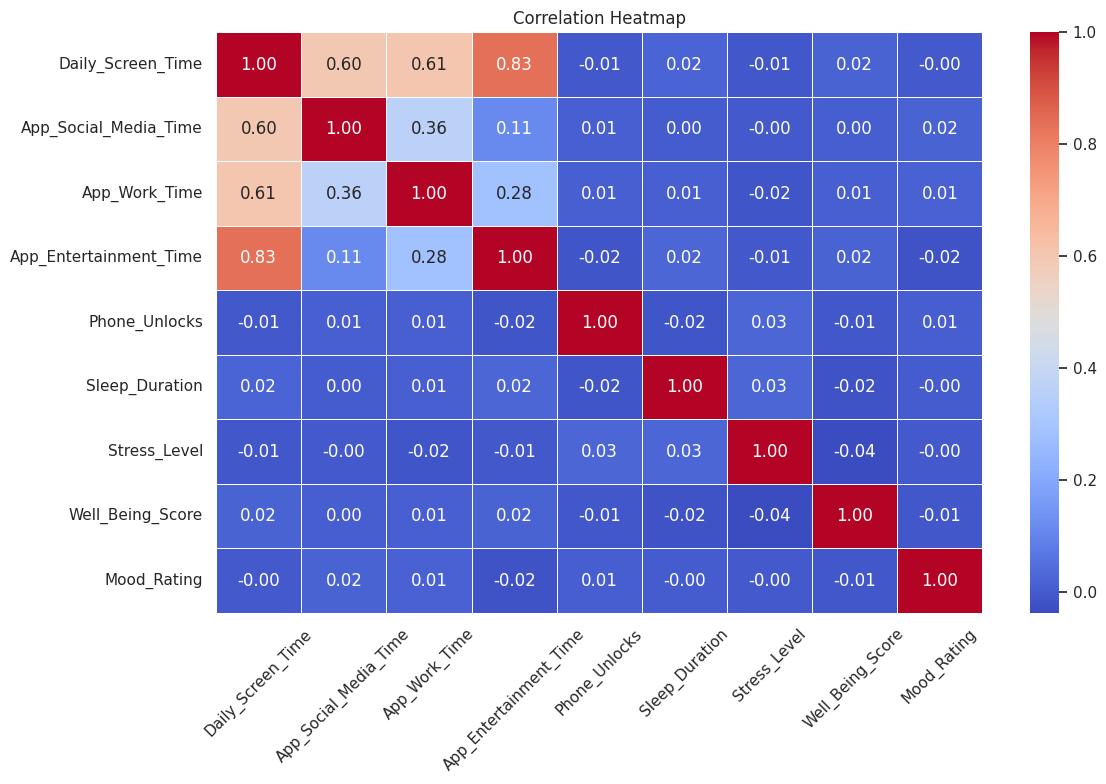

In [37]:
#Select relevant numerical columns for correlation analysis
selected_columns = [ 'Daily_Screen_Time', 'App_Social_Media_Time', 'App_Work_Time',
                     'App_Entertainment_Time', 'Phone_Unlocks', 'Sleep_Duration',
                     'Stress_Level', 'Well_Being_Score', 'Mood_Rating']

# Filter the dataset to include only these columns
df_selected = df_mental_health_merged[selected_columns]

#Generate the correlation matrix
correlation_matrix = df_selected.corr()

# Step 3: Plot the heatmap
plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(
    correlation_matrix,         # Correlation matrix as input
    annot=True,                 # Display the correlation coefficients in the cells
    cmap='coolwarm',            # Use a diverging colormap (red-blue)
    fmt=".2f",                  # Format correlation values to 2 decimal places
    linewidths=0.5              # Add lines between the cells for readability
)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Box plots – comparing screen time across age groups and productivity levels and Stress Level by Notification Handling

<ipython-input-38-dd361827c05e>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




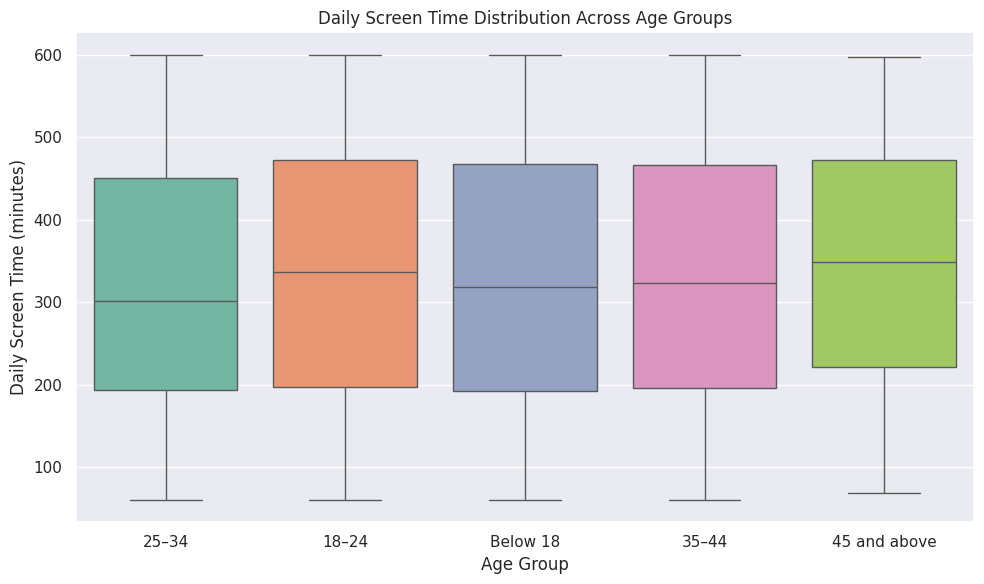

<ipython-input-38-dd361827c05e>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




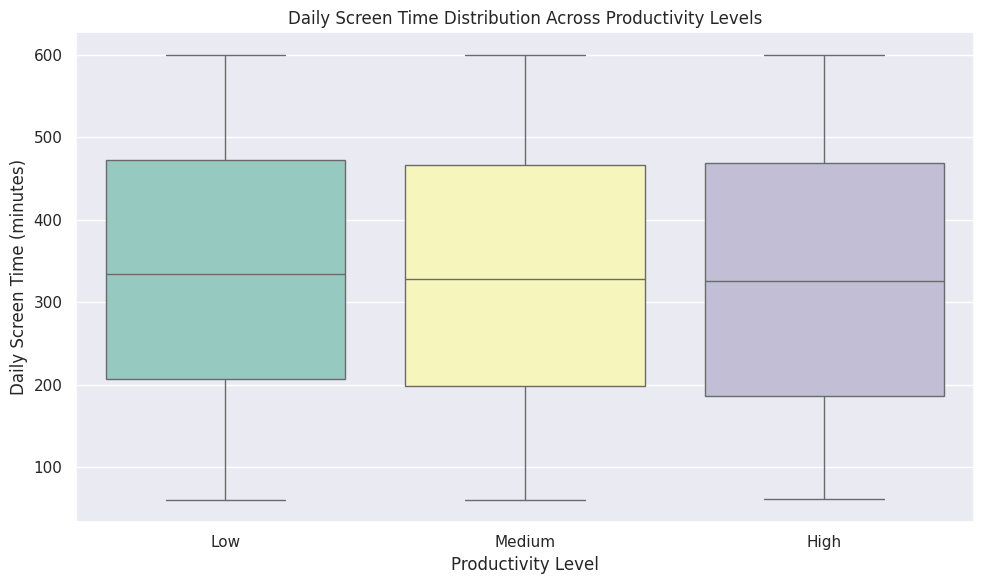

In [38]:
# Create productivity level categories
df_mental_health_encoded['Productivity_Level'] = pd.cut(df_mental_health_encoded['Productivity'], bins=3, labels=["Low", "Medium", "High"])

# Box plot 1: Daily Screen Time vs. Age Group
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age Group', y='Daily_Screen_Time', data=df_mental_health_encoded, palette='Set2')
plt.title('Daily Screen Time Distribution Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Daily Screen Time (minutes)')
plt.tight_layout()
plt.show()

# Box plot 2: Daily Screen Time vs. Productivity Level
plt.figure(figsize=(10, 6))
sns.boxplot(x='Productivity_Level', y='Daily_Screen_Time', data=df_mental_health_encoded, palette='Set3')
plt.title('Daily Screen Time Distribution Across Productivity Levels')
plt.xlabel('Productivity Level')
plt.ylabel('Daily Screen Time (minutes)')
plt.tight_layout()
plt.show()


Bivariate Analysis: Stress Level by Notification Handling:


<ipython-input-39-d89da31507e6>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




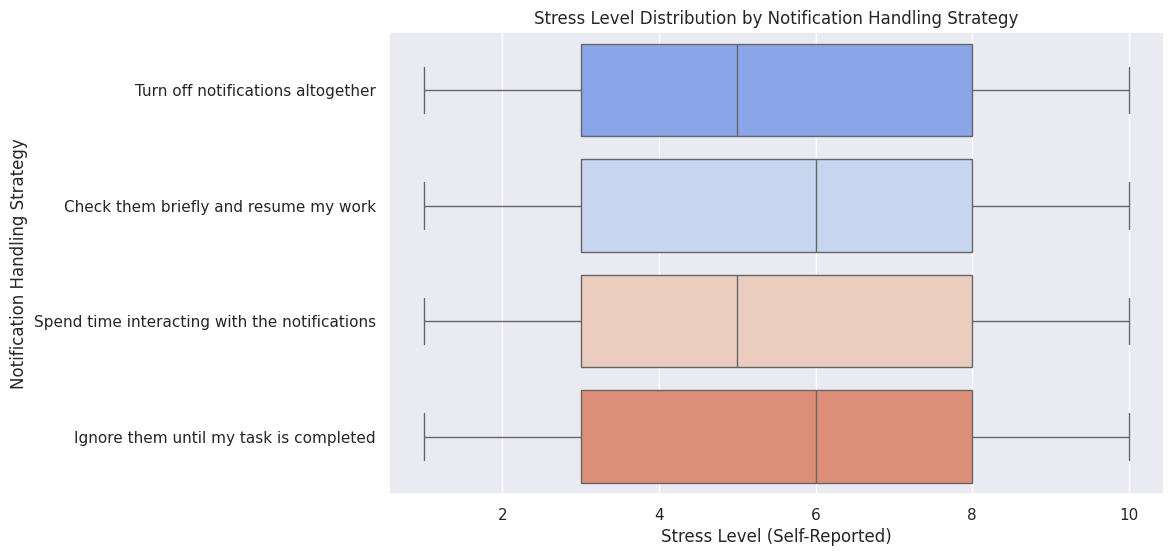

In [39]:
# Bivariate Analysis
print("\nBivariate Analysis: Stress Level by Notification Handling:")
if 'Stress_Level' in df_mental_health_merged_reordered.columns and 'Notification Handling' in df_mental_health_merged_reordered.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_mental_health_merged_reordered, x='Stress_Level', y='Notification Handling', palette='coolwarm')
    plt.title('Stress Level Distribution by Notification Handling Strategy')
    plt.xlabel('Stress Level (Self-Reported)')
    plt.ylabel('Notification Handling Strategy')
    plt.show()
else:
     print("Warning: 'Stress_Level' or 'Notification_Handling' column missing.")


Bivariate Analysis: Mood Rating by Work Strategy:


<ipython-input-40-d6a5c96cdfb3>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




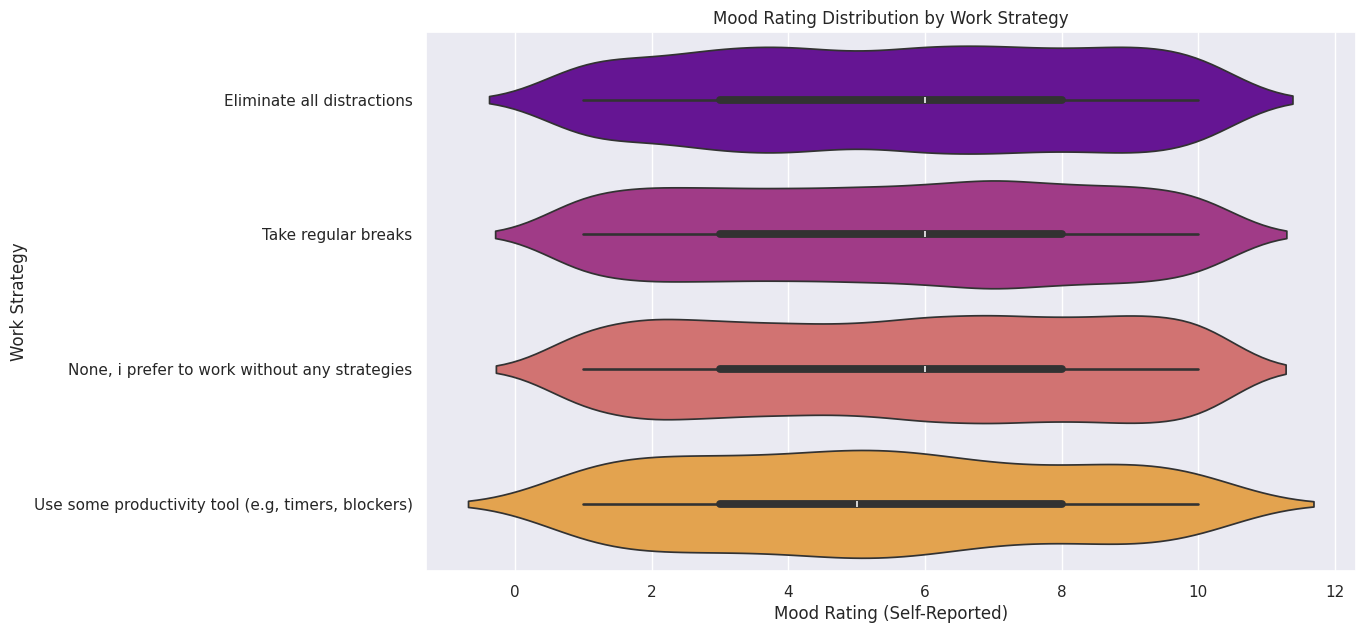

In [40]:
# Bivariate Analysis
print("\nBivariate Analysis: Mood Rating by Work Strategy:")
if 'Mood_Rating' in df_mental_health_merged_reordered.columns and 'Work Strategy' in df_mental_health_merged_reordered.columns:
    plt.figure(figsize=(12, 7))
    sns.violinplot(data=df_mental_health_merged_reordered, x='Mood_Rating', y='Work Strategy', palette='plasma')
    plt.title('Mood Rating Distribution by Work Strategy')
    plt.xlabel('Mood Rating (Self-Reported)')
    plt.ylabel('Work Strategy')
    plt.show()
else:
     print("Warning: 'Mood_Rating' or 'Work_Strategy' column missing.")

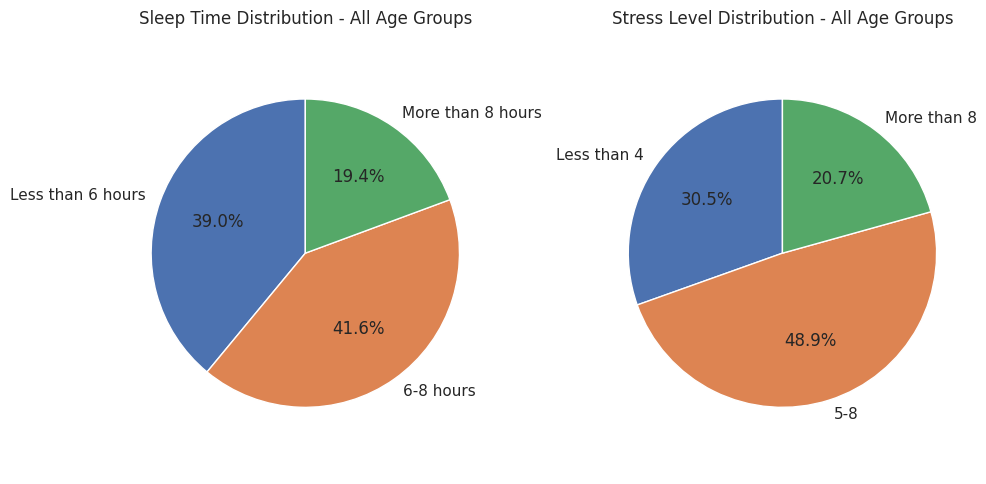

In [41]:
#Sleep Time Distribution
sleep_time_categories = ['Less than 6 hours', '6-8 hours', 'More than 8 hours']
Stress_Level_categories = ['Less than 4', '5-8', 'More than 8']
# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first pie chart
sleep_time_counts1 = [len(df_mental_health_merged[(df_mental_health_merged['Sleep_Duration'] < 6)]),
                      len(df_mental_health_merged[(df_mental_health_merged['Sleep_Duration'] >= 6) & (df_mental_health_merged['Sleep_Duration'] <= 8)]),
                      len(df_mental_health_merged[(df_mental_health_merged['Sleep_Duration'] > 8)])]
ax1.pie(sleep_time_counts1, labels=sleep_time_categories, autopct='%1.1f%%', startangle=90)
ax1.set_title('Sleep Time Distribution - All Age Groups')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#Stress Level
# Plot the second pie chart
# Filter by single value
sleep_time_counts2 = [len(df_mental_health_merged[(df_mental_health_merged['Stress_Level'] < 4)]),
                      len(df_mental_health_merged[(df_mental_health_merged['Stress_Level'] >= 5) & (df_mental_health_merged['Sleep_Duration'] <= 8)]),
                      len(df_mental_health_merged[(df_mental_health_merged['Stress_Level'] > 8)])]
ax2.pie(sleep_time_counts2, labels=Stress_Level_categories, autopct='%1.1f%%', startangle=90)
ax2.set_title('Stress Level Distribution - All Age Groups')
ax2.axis('equal')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



Bar Plots for Key Categorical Variables:


<ipython-input-42-1230fd57aa61>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-42-1230fd57aa61>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-42-1230fd57aa61>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-42-1230fd57aa61>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-42-1230fd57aa61>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be

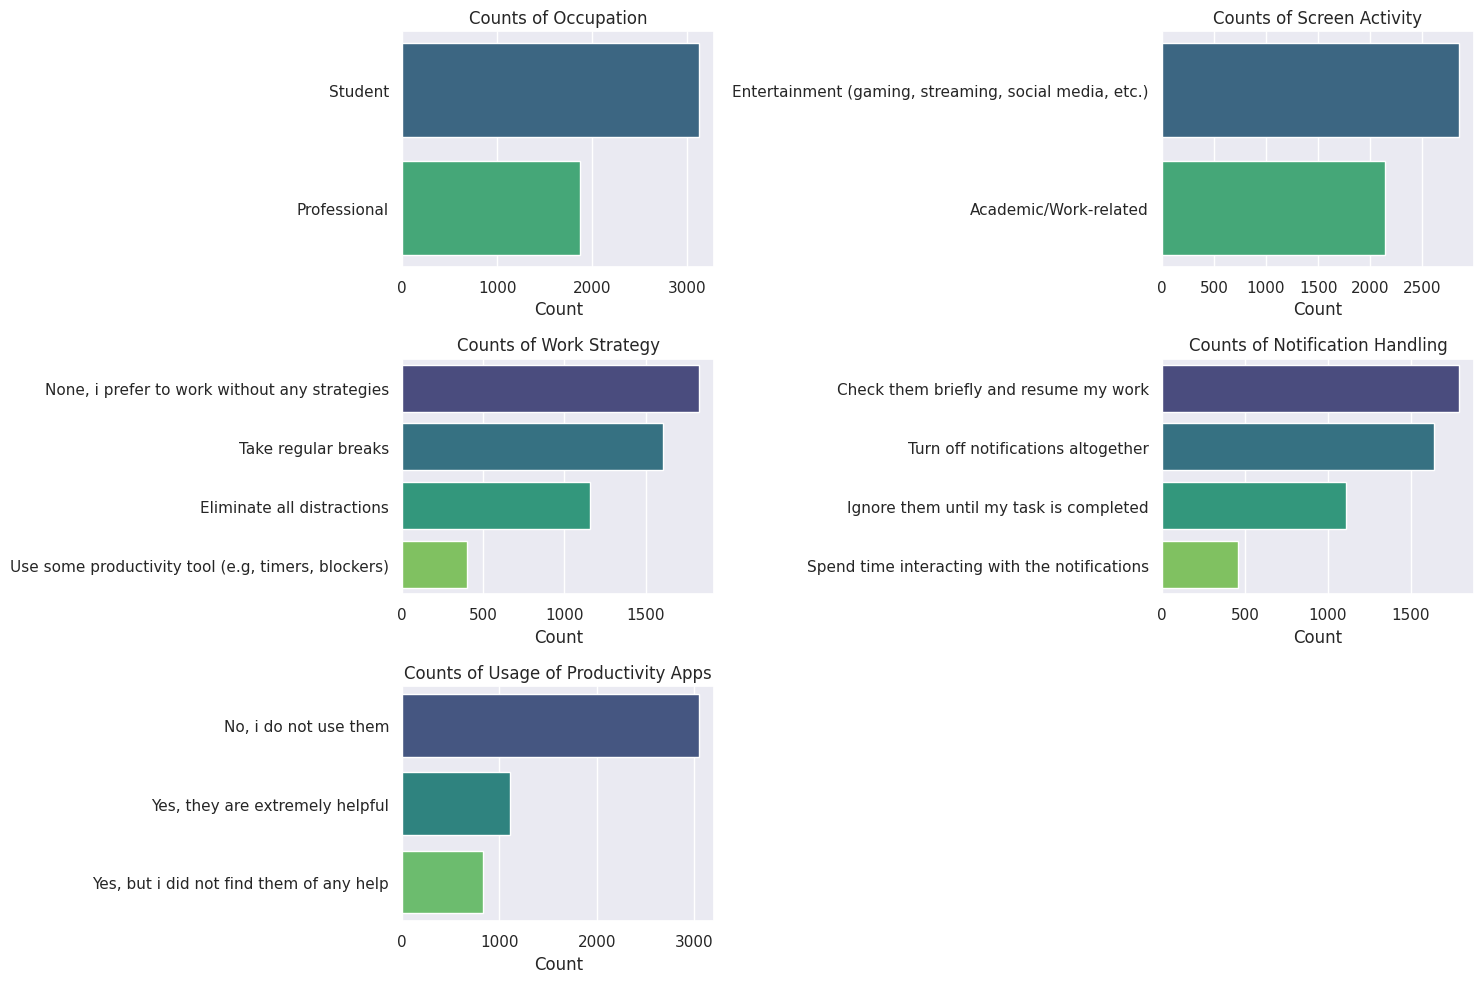

In [42]:
# Univariate Analysis (Counts of Key Categorical Variables)
print("\nBar Plots for Key Categorical Variables:")
eda_categorical_cols = ['Occupation', 'Screen Activity', 'Work Strategy', 'Notification Handling', 'Usage of Productivity Apps']
plt.figure(figsize=(15, 10))
for i, col in enumerate(eda_categorical_cols):
    if col in df_mental_health_merged_reordered.columns:
        plt.subplot(3, 2, i + 1)
        sns.countplot(y=df_mental_health_merged_reordered[col], order=df_mental_health_merged_reordered[col].value_counts().index, palette='viridis')
        plt.title(f'Counts of {col}')
        plt.xlabel('Count')
        plt.ylabel('') # Remove y-axis label for clarity with horizontal bars
    else:
         print(f"Warning: Categorical column '{col}' not found.")

plt.tight_layout()
plt.show()

---
**Use appropriate ML methods**



In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils import class_weight # To handle potential imbalance

# --- 1. Load Data ---
# Datset file present in "/content/drive/My Drive/ColabNotebooks/"
file_path = 'df_mental_health_merged_reordered.csv'
try:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()



Dataset loaded successfully. Shape: (5000, 20)


In [44]:
# --- 2. Data Cleaning and Preprocessing ---
df.columns = df.columns.str.replace(' ', '_', regex=False).str.replace('[^A-Za-z0-9_]+', '', regex=True)
df['Gender_Male'] = df['Gender_Male'].astype(int) # Convert boolean to int

# Filter for the target age group (18-34)
age_groups_to_include = ['18–24', '25–34']
df_filtered = df[df['Age_Group'].isin(age_groups_to_include)].copy()
print(f"\nFiltered dataset shape (Age 18-34): {df_filtered.shape}")


Filtered dataset shape (Age 18-34): (3734, 20)


In [45]:
# --- 3. Define Target Variable ---
# Define 'High Stress' threshold (Stress_Level > 7)
stress_threshold = 7
target_col = 'Stress_Level' # Define the source column name explicitly

if target_col not in df_filtered.columns:
     print(f"Error: Target column '{target_col}' not found. Cannot create 'Is_High_Stress'.")
     exit()

df_filtered['Is_High_Stress'] = (df_filtered[target_col] > stress_threshold).astype(int)
print("\nTarget Variable Distribution ('Is_High_Stress'):")
print(df_filtered['Is_High_Stress'].value_counts(normalize=True) * 100)
target_imbalance_ratio = df_filtered['Is_High_Stress'].mean() # Proportion of positive class


Target Variable Distribution ('Is_High_Stress'):
Is_High_Stress
0    70.755222
1    29.244778
Name: proportion, dtype: float64


In [46]:
# --- 4. Feature Selection ---
# Digital behaviors + Demographics + Sleep (as a key indicator)
# Predictor Variables (Features)
feature_cols_numeric = [
    'Daily_Screen_Time', 'App_Social_Media_Time', 'App_Work_Time',
    'App_Entertainment_Time', 'Phone_Unlocks', 'Sleep_Duration'
]
feature_cols_categorical = [
    'Gender_Male', 'Age_Group', 'Occupation'
]

# Ensure all selected feature columns exist
all_feature_cols = feature_cols_numeric + feature_cols_categorical
missing_features = [col for col in all_feature_cols if col not in df_filtered.columns]
if missing_features:
    print(f"\nError: The following feature columns are missing: {missing_features}")
    print("Please check column names after cleaning.")
    # Filter out missing columns to proceed if possible, or exit
    feature_cols_numeric = [col for col in feature_cols_numeric if col in df_filtered.columns]
    feature_cols_categorical = [col for col in feature_cols_categorical if col in df_filtered.columns]
    all_feature_cols = feature_cols_numeric + feature_cols_categorical
    if not all_feature_cols:
        print("No valid feature columns remain. Exiting.")
        exit()
    else:
        print(f"Proceeding with available features: {all_feature_cols}")


# Prepare X and y, dropping rows with NaNs in selected features or target
X = df_filtered[all_feature_cols].copy()
y = df_filtered['Is_High_Stress'].copy()
X = X.dropna()
y = y[X.index] # Align target with features after dropping NaNs

print(f"\nShape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")

if X.empty or y.empty:
    print("Error: No data left after dropping NaNs. Check input data and selected features.")
    exit()


Shape of X (features): (3734, 9)
Shape of y (target): (3734,)


In [47]:
# --- 5. Data Splitting ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y # Stratify preserves class proportion
)
print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# --- 6. Preprocessing Pipeline (Scaling & Encoding) ---
# Create preprocessing pipelines for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # drop='first' avoids multicollinearity
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, feature_cols_numeric),
        ('cat', categorical_transformer, feature_cols_categorical)
    ],
    remainder='passthrough' # Keep any columns not specified (though we specified all)
)

Train set size: 2800, Test set size: 934


In [ ]:
# --- 7. Define and Train Models ---
# Note: Using class_weight='balanced' directly in models is often easier

# --- Model 1: Random Forest ---
print("\n--- Training Random Forest ---")
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42,
                                         n_estimators=100, # Default, can tune
                                         class_weight='balanced', # Handles imbalance
                                         n_jobs=-1)) # Use all available CPU cores
])

rf_pipeline.fit(X_train, y_train)

In [ ]:
# --- Model 2: Logistic Regression ---
print("\n--- Training Logistic Regression ---")
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42,
                                      class_weight='balanced', # Handles imbalance
                                      solver='liblinear', # Good for smaller datasets
                                      max_iter=1000))
])

logreg_pipeline.fit(X_train, y_train)


--- Model Evaluation ---

--- Random Forest Results ---
Accuracy: 0.7002141327623126

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.98      0.82       661
           1       0.35      0.03      0.05       273

    accuracy                           0.70       934
   macro avg       0.53      0.50      0.44       934
weighted avg       0.60      0.70      0.60       934


Confusion Matrix:
[[646  15]
 [265   8]]


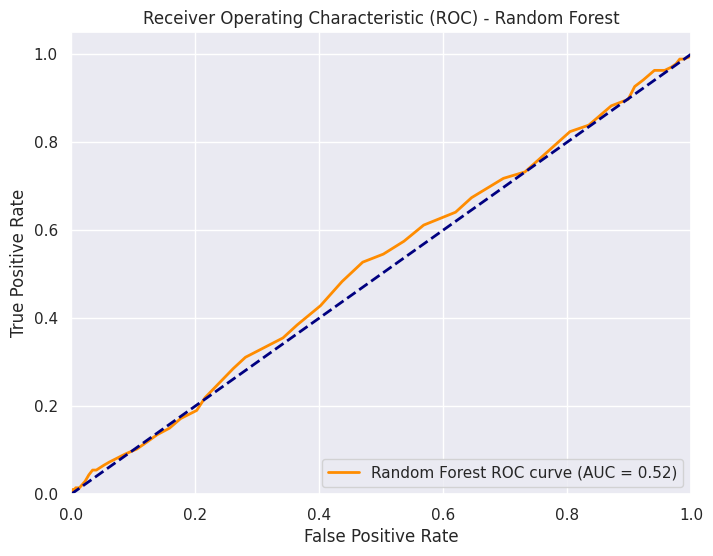

In [49]:
# --- 8. Evaluate Models ---
print("\n--- Model Evaluation ---")

# Predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1] # Probabilities for ROC/AUC

y_pred_logreg = logreg_pipeline.predict(X_test)
y_prob_logreg = logreg_pipeline.predict_proba(X_test)[:, 1]

# --- Random Forest Evaluation ---
print("\n--- Random Forest Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# ROC Curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


--- Logistic Regression Results ---
Accuracy: 0.5171306209850107

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.51      0.60       661
           1       0.31      0.55      0.40       273

    accuracy                           0.52       934
   macro avg       0.52      0.53      0.50       934
weighted avg       0.61      0.52      0.54       934


Confusion Matrix:
[[334 327]
 [124 149]]


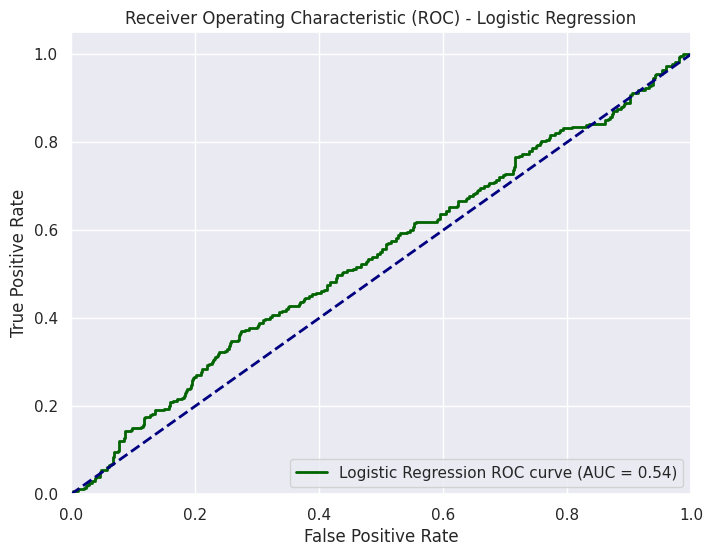

In [50]:
# --- Logistic Regression Evaluation ---
print("\n--- Logistic Regression Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

# ROC Curve and AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_logreg)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkgreen', lw=2, label=f'Logistic Regression ROC curve (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


--- Feature Importances ---

Random Forest Feature Importances:
                  Feature  Importance
3  App_Entertainment_Time    0.166565
1   App_Social_Media_Time    0.159607
4           Phone_Unlocks    0.158789
0       Daily_Screen_Time    0.158527
2           App_Work_Time    0.148324
5          Sleep_Duration    0.148031
6           Gender_Male_1    0.023531
8      Occupation_Student    0.021557
7         Age_Group_25–34    0.015069


<ipython-input-51-aadcb63aed30>:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




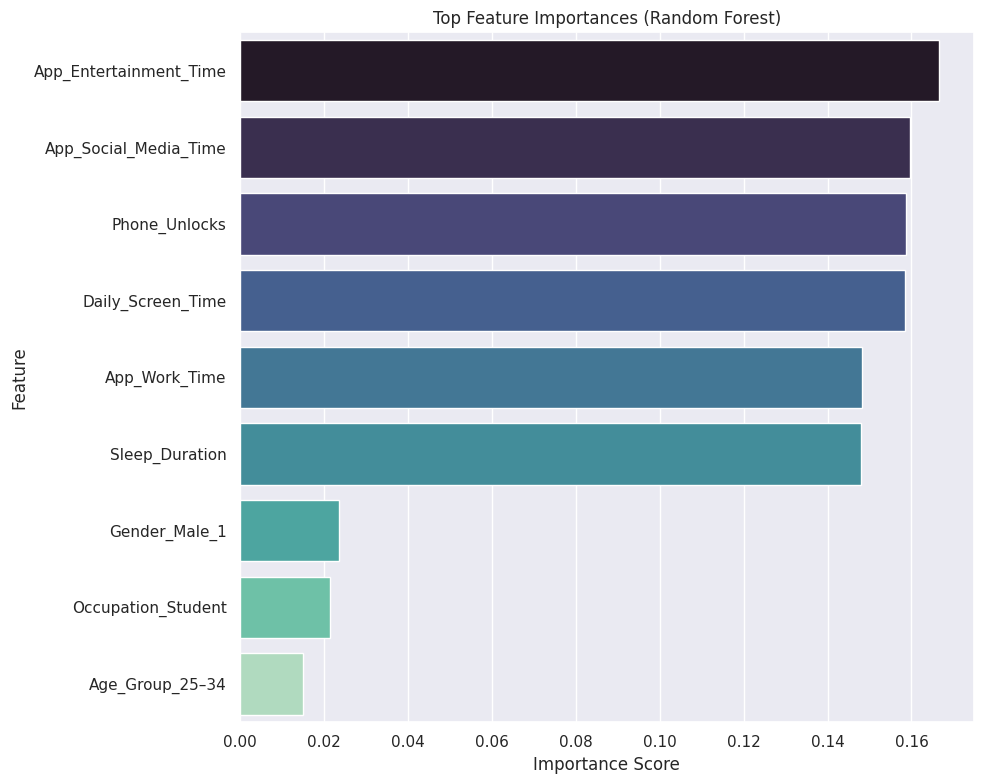

In [51]:
# --- 9. Feature Importance ---
print("\n--- Feature Importances ---")

# --- Random Forest Feature Importance ---
try:
    # Get feature names after one-hot encoding
    ohe_feature_names = list(rf_pipeline.named_steps['preprocessor']
                             .named_transformers_['cat']
                             .named_steps['onehot']
                             .get_feature_names_out(feature_cols_categorical))
    # Combine numeric and OHE feature names
    all_processed_feature_names = feature_cols_numeric + ohe_feature_names

    importances_rf = rf_pipeline.named_steps['classifier'].feature_importances_

    feature_importance_rf = pd.DataFrame({
        'Feature': all_processed_feature_names,
        'Importance': importances_rf
    }).sort_values('Importance', ascending=False)

    print("\nRandom Forest Feature Importances:")
    print(feature_importance_rf)

    # Plotting Feature Importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_rf.head(15), palette='mako') # Show top 15
    plt.title('Top Feature Importances (Random Forest)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error extracting/plotting RF feature importance: {e}")


Logistic Regression Coefficients (Sorted by Absolute Value):
                  Feature  Coefficient
8      Occupation_Student    -0.147768
6           Gender_Male_1    -0.107408
4           Phone_Unlocks     0.097507
5          Sleep_Duration     0.057601
7         Age_Group_25–34    -0.052521
2           App_Work_Time    -0.046631
3  App_Entertainment_Time     0.035331
0       Daily_Screen_Time     0.018492
1   App_Social_Media_Time     0.011953


<ipython-input-52-3cd41758dddf>:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




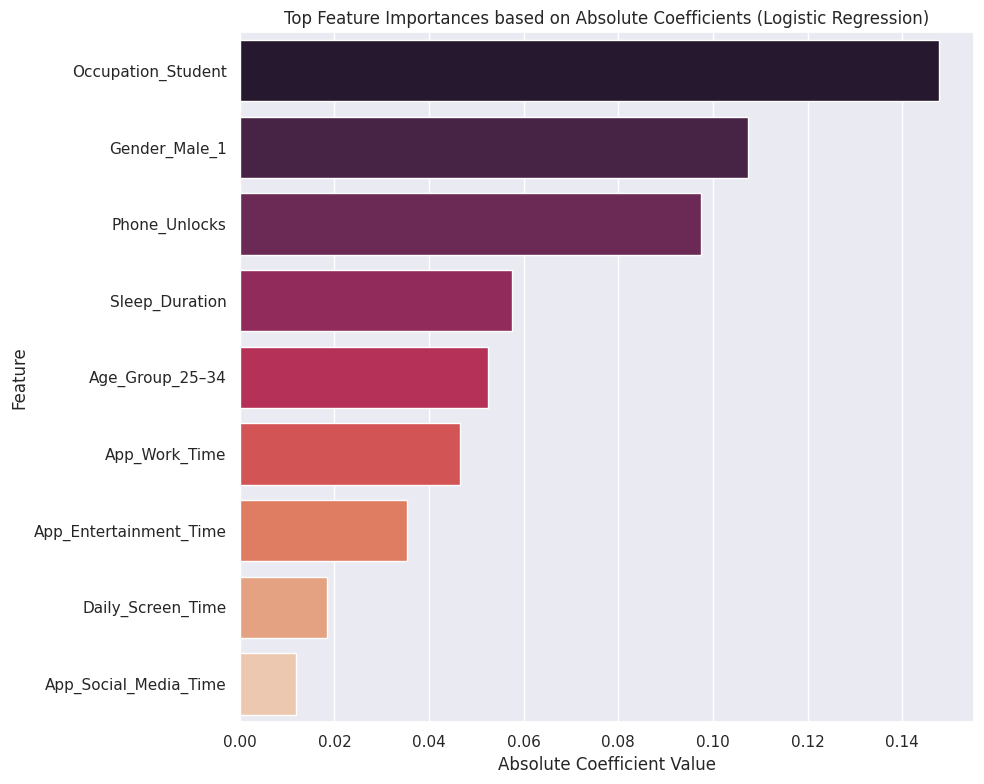

In [52]:
# --- Logistic Regression Feature Importance (Coefficients) ---
try:
    # Get feature names (same as RF)
    coefficients_lr = logreg_pipeline.named_steps['classifier'].coef_[0] # coef_[0] because it's binary classification

    # Use absolute value for importance magnitude ranking
    feature_importance_lr = pd.DataFrame({
        'Feature': all_processed_feature_names,
        'Coefficient': coefficients_lr,
        'Abs_Coefficient': np.abs(coefficients_lr)
    }).sort_values('Abs_Coefficient', ascending=False)

    print("\nLogistic Regression Coefficients (Sorted by Absolute Value):")
    print(feature_importance_lr[['Feature', 'Coefficient']])

    # Plotting Absolute Coefficients
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance_lr.head(15), palette='rocket') # Show top 15
    plt.title('Top Feature Importances based on Absolute Coefficients (Logistic Regression)')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error extracting/plotting LR feature coefficients: {e}")

In [53]:
# --- 10. Interpretation of Feature Importances ---
print("\n--- Interpretation ---")
print(f"Based on the Random Forest feature importances (which directly address the question):")
if 'feature_importance_rf' in locals():
    top_features = feature_importance_rf['Feature'].head(5).tolist() # Get top 5
    print(f"The features most strongly associated with high stress (Stress Level > {stress_threshold}) appear to be:")
    for i, feature in enumerate(top_features):
        print(f"  {i+1}. {feature}")
    print("\nThis suggests that [interpret the specific top features - e.g., 'Sleep Duration appears crucial, followed by Social Media Time...']")
    print("Comparing digital behaviours: Look at the relative ranking of App_Social_Media_Time vs App_Work_Time etc.")
    print("Comparing demographics: How important are Gender, Age Group (within 18-34), or Occupation compared to usage metrics?")
else:
    print("Could not determine top features due to earlier errors.")

print("\nThe Logistic Regression coefficients provide insight into the direction of association (positive/negative coefficient) for scaled features.")
print("Model performance metrics (Accuracy, AUC, Classification Report) indicate how well the models distinguish between high/low stress groups.")

print("\nFeature Importance Interpretation:")
print("These plots directly address the research question by ranking features.")
print("Higher bars indicate features the model found more predictive of high stress.")
print("Compare the rankings between RF and LR for robustness.")
print(f"The top features overall seem to be: {feature_importance_rf['Feature'].iloc[0]}, {feature_importance_rf['Feature'].iloc[1]}, {feature_importance_rf['Feature'].iloc[2]} (based on RF).")



--- Interpretation ---
Based on the Random Forest feature importances (which directly address the question):
The features most strongly associated with high stress (Stress Level > 7) appear to be:
  1. App_Entertainment_Time
  2. App_Social_Media_Time
  3. Phone_Unlocks
  4. Daily_Screen_Time
  5. App_Work_Time

This suggests that [interpret the specific top features - e.g., 'Sleep Duration appears crucial, followed by Social Media Time...']
Comparing digital behaviours: Look at the relative ranking of App_Social_Media_Time vs App_Work_Time etc.
Comparing demographics: How important are Gender, Age Group (within 18-34), or Occupation compared to usage metrics?

The Logistic Regression coefficients provide insight into the direction of association (positive/negative coefficient) for scaled features.
Model performance metrics (Accuracy, AUC, Classification Report) indicate how well the models distinguish between high/low stress groups.

Feature Importance Interpretation:
These plots dir

**Visualizations based on the results of the Random Forest and Logistic Regression models**


--- Plotting ROC Curves ---


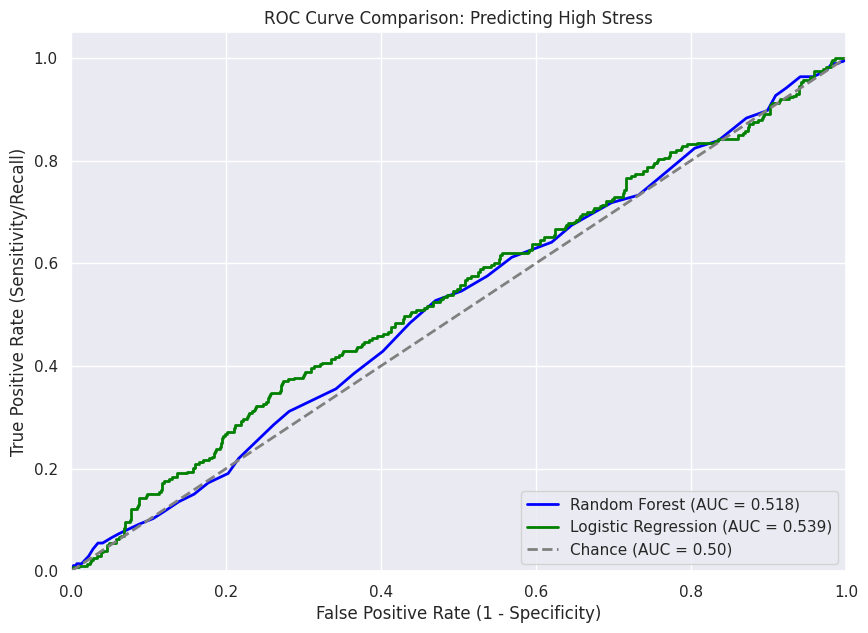


ROC Interpretation:
The ROC curve shows the trade-off between correctly identifying high-stress individuals (TPR)
and incorrectly flagging lower-stress individuals as high-stress (FPR).
The Area Under the Curve (AUC) summarizes overall discriminative ability.
Higher AUC (closer to 1.0) indicates better model performance.

--- Plotting Confusion Matrices ---


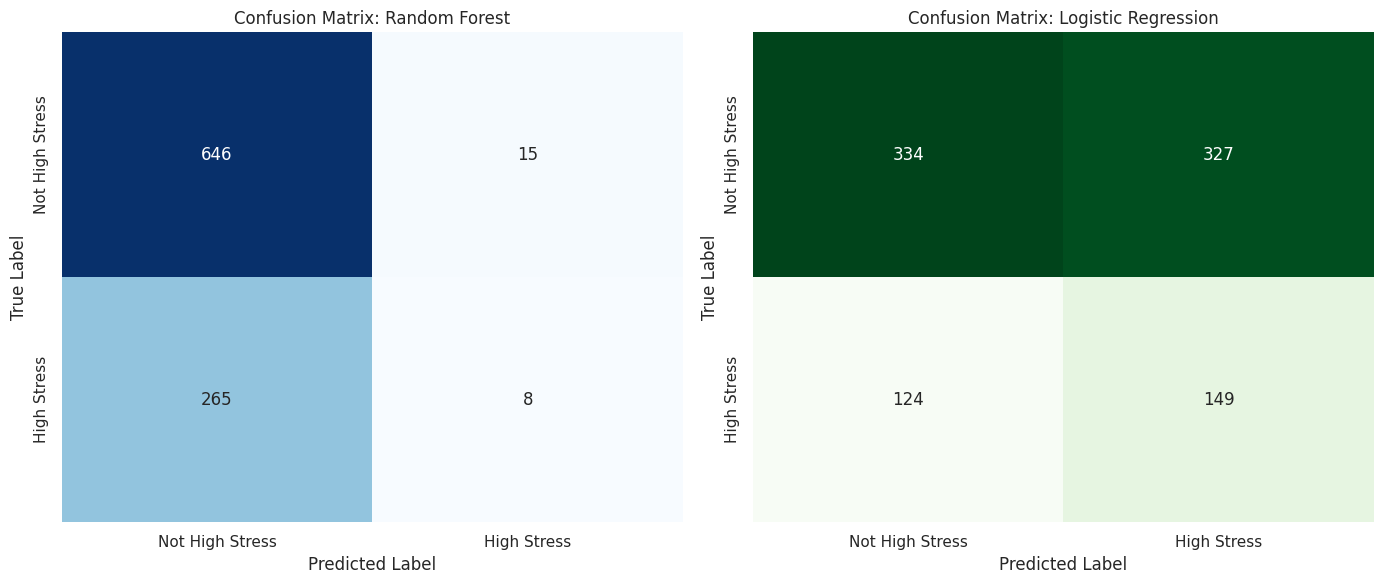


Confusion Matrix Interpretation:
Shows the breakdown of predictions:
 - Top-Left: True Negatives (Correctly predicted 'Not High Stress')
 - Top-Right: False Positives (Incorrectly predicted 'High Stress')
 - Bottom-Left: False Negatives (Incorrectly predicted 'Not High Stress')
 - Bottom-Right: True Positives (Correctly predicted 'High Stress')
Compare the patterns between the two models.


In [54]:
# --- Visualization 1: Model Performance Comparison (ROC Curves) ---
print("\n--- Plotting ROC Curves ---")
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_logreg)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 7))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--', label='Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve Comparison: Predicting High Stress')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\nROC Interpretation:")
print("The ROC curve shows the trade-off between correctly identifying high-stress individuals (TPR)")
print("and incorrectly flagging lower-stress individuals as high-stress (FPR).")
print("The Area Under the Curve (AUC) summarizes overall discriminative ability.")
print("Higher AUC (closer to 1.0) indicates better model performance.")


# --- Visualization 2: Confusion Matrices ---
print("\n--- Plotting Confusion Matrices ---")

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix: Random Forest')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].xaxis.set_ticklabels(['Not High Stress', 'High Stress'])
axes[0].yaxis.set_ticklabels(['Not High Stress', 'High Stress'])

sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title('Confusion Matrix: Logistic Regression')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].xaxis.set_ticklabels(['Not High Stress', 'High Stress'])
axes[1].yaxis.set_ticklabels(['Not High Stress', 'High Stress'])

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Interpretation:")
print("Shows the breakdown of predictions:")
print(" - Top-Left: True Negatives (Correctly predicted 'Not High Stress')")
print(" - Top-Right: False Positives (Incorrectly predicted 'High Stress')")
print(" - Bottom-Left: False Negatives (Incorrectly predicted 'Not High Stress')")
print(" - Bottom-Right: True Positives (Correctly predicted 'High Stress')")
print("Compare the patterns between the two models.")